<a href="https://colab.research.google.com/github/mukulre/Projects/blob/main/PneumoNet_COVID_Detection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import(Dense, GlobalAveragePooling2D, Input, Conv2D, Multiply, Add, Activation, Lambda)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
IMG_SIZE=300
BATCH_SIZE=16

train_datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
train_generator=train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Pneumonet',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
val_generator=train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Pneumonet',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 5523 images belonging to 3 classes.
Found 1379 images belonging to 3 classes.


In [6]:
from tensorflow.keras.layers import Concatenate

def cbam_block(feature_map, ratio=8):
  channel=int(feature_map.shape[-1])

  shared_dense_one=Dense(channel//ratio, activation='relu')
  shared_dense_two=Dense(channel)

  avg_pool=Lambda(lambda x:tf.reduce_mean(x,axis=[1,2],keepdims=True))(feature_map)
  max_pool=Lambda(lambda x:tf.reduce_max(x,axis=[1,2],keepdims=True))(feature_map)

  mlp_avg=shared_dense_two(shared_dense_one(avg_pool))
  mlp_max=shared_dense_two(shared_dense_one(max_pool))

  channel_attention=Activation('sigmoid')(Add()([mlp_avg, mlp_max]))
  channel_refined=Multiply()([feature_map, channel_attention])

  avg_pool_spatial=Lambda(lambda x:tf.reduce_mean(x,axis=-1,keepdims=True))(channel_refined)
  max_pool_spatial=Lambda(lambda x:tf.reduce_max(x,axis=-1,keepdims=True))(channel_refined)
  concat=Concatenate(axis=-1)([avg_pool_spatial,max_pool_spatial])

  spatial_attention=Conv2D(1,kernel_size=7,padding='same',activation='sigmoid')(concat)
  refined_feature=Multiply()([channel_refined,spatial_attention])

  return refined_feature

In [7]:
base_model=EfficientNetB3(include_top=False,weights='imagenet',input_shape=(IMG_SIZE, IMG_SIZE,3))
x=base_model.output
x=cbam_block(x)
x=GlobalAveragePooling2D()(x)
x=Dense(128, activation='relu')(x)
output=Dense(3, activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=output)
model.compile(optimizer=Adam(1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,572,309 (44.14 MB)

 Trainable params: 11,485,006 (43.81 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [8]:
history=model.fit(train_generator,
                  validation_data=val_generator,
                  epochs=50,
                  callbacks=[
                      EarlyStopping(patience=5, restore_best_weights=True),
                      ModelCheckpoint('cbam_effnetb3_final.h5',save_best_only=True)
                  ]
                )
model.save('cbam_effnetb3_final.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7993 - loss: 0.6098

346/346 ━━━━━━━━━━━━━━━━━━━━ 2080s 6s/step - accuracy: 0.7996 - loss: 0.6090 - val_accuracy: 0.3328 - val_loss: 2.0531
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 253s 731ms/step - accuracy: 0.9570 - loss: 0.1228 - val_accuracy: 0.3299 - val_loss: 3.3539
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.9735 - loss: 0.0742

346/346 ━━━━━━━━━━━━━━━━━━━━ 249s 719ms/step - accuracy: 0.9735 - loss: 0.0742 - val_accuracy: 0.6657 - val_loss: 1.5788
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 288s 831ms/step - accuracy: 0.9786 - loss: 0.0603 - val_accuracy: 0.3561 - val_loss: 382.0446
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 251s 724ms/step - accuracy: 0.9806 - loss: 0.0572 - val_accuracy: 0.3169 - val_loss: 5.6210
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 296s 823ms/step - accuracy: 0.9819 - loss: 0.0544 - val_accuracy: 0.3996 - val_loss: 20.1932
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 287s 719ms/step - accuracy: 0.9897 - loss: 0.0307 - val_accuracy: 0.3350 - val_loss: 559.2855
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 250s 722ms/step - accuracy: 0.9904 - loss: 0.0303 - val_accuracy: 0.3872 - val_loss: 3.0553


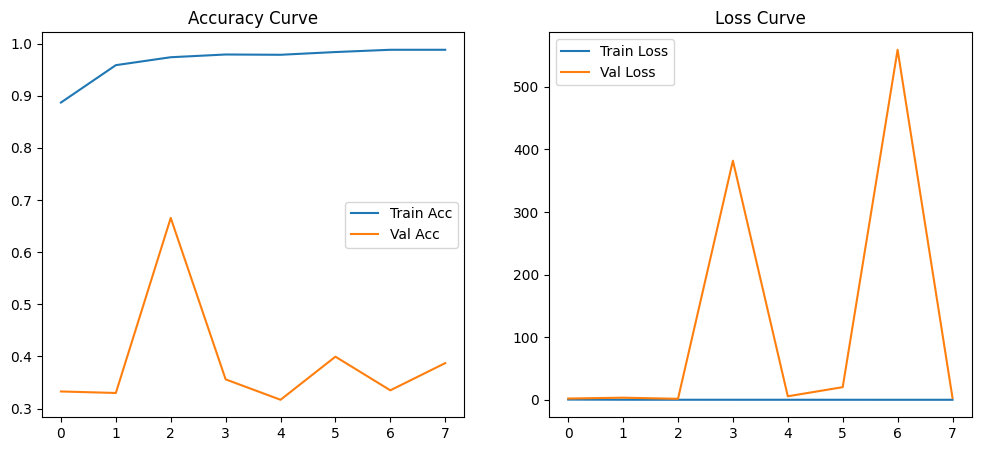

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy Curve')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss Curve')
plt.show()

86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 529ms/step


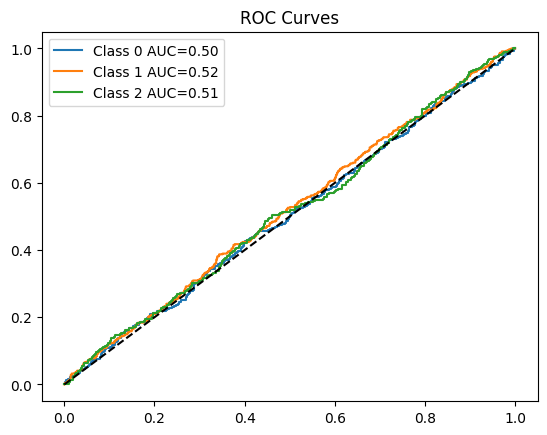

In [10]:
val_steps=val_generator.samples // val_generator.batch_size
y_true=val_generator.classes[:val_steps*BATCH_SIZE]
y_pred=model.predict(val_generator, steps=val_steps)
y_score=y_pred[:len(y_true)]
y_true_bin=label_binarize(y_true, classes=[0,1,2])

fpr={}; tpr={}; roc_auc={}
for i in range(3):
  fpr[i], tpr[i], _=roc_curve(y_true_bin[:,i], y_score[:,i])
  roc_auc[i]=auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
  plt.plot(fpr[i],tpr[i],label=f'Class {i} AUC={roc_auc[i]:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.legend(); plt.title('ROC Curves')
plt.show()

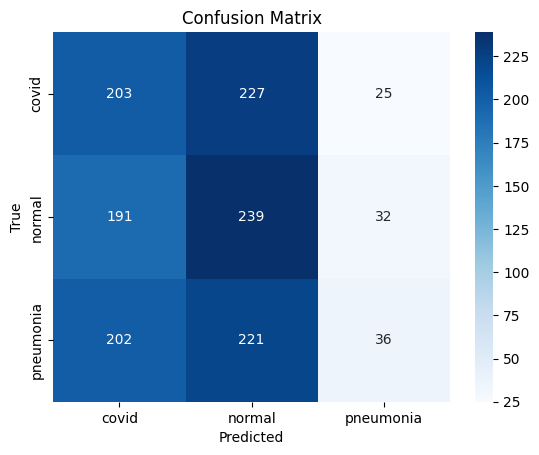

              precision    recall  f1-score   support

       covid       0.34      0.45      0.39       455
      normal       0.35      0.52      0.42       462
   pneumonia       0.39      0.08      0.13       459

    accuracy                           0.35      1376
   macro avg       0.36      0.35      0.31      1376
weighted avg       0.36      0.35      0.31      1376



In [11]:
y_pred_classes=np.argmax(y_score,axis=1)
cm=confusion_matrix(y_true,y_pred_classes)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=train_generator.class_indices,yticklabels=train_generator.class_indices)
plt.title('Confusion Matrix');plt.xlabel('Predicted');plt.ylabel('True')
plt.show()

print(classification_report(y_true,y_pred_classes,target_names=train_generator.class_indices))

In [12]:
# Save model
model.save('cbam_model.h5')

# Save training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


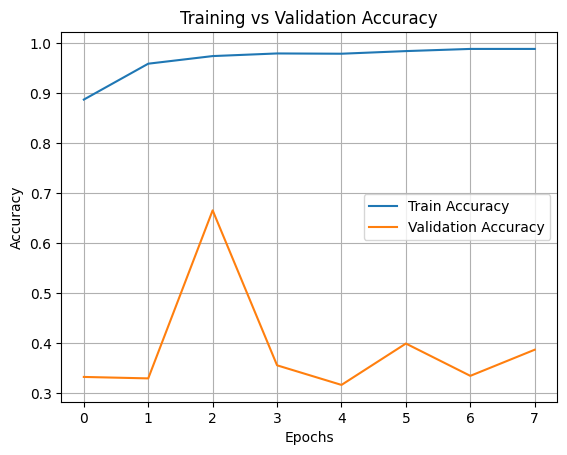

In [27]:
# After training
#history = model.fit(history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))
#)  # your training code

# Plot accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.show()


86/86 ━━━━━━━━━━━━━━━━━━━━ 48s 563ms/step


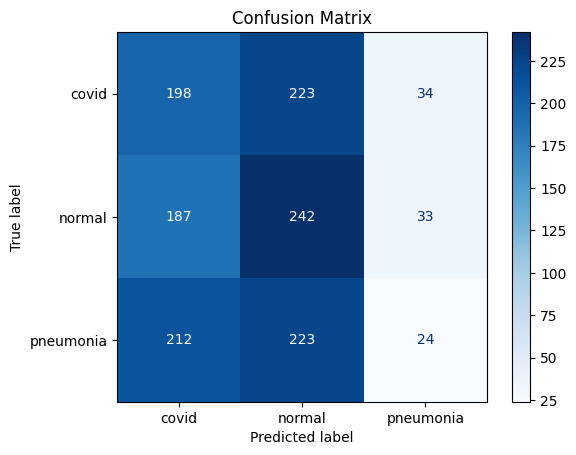

In [31]:
val_steps = val_generator.samples // val_generator.batch_size
y_pred = model.predict(val_generator, steps=val_steps)
y_true = val_generator.classes[:val_steps * val_generator.batch_size]
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


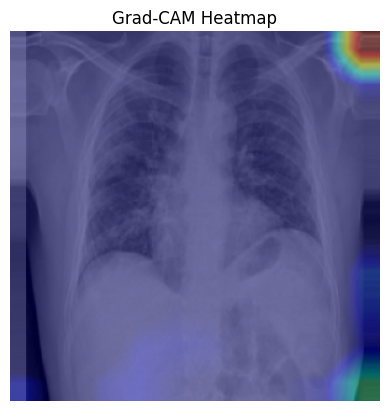

In [38]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_gradcam_heatmap(model, image, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    cam = np.maximum(cam, 0)
    heatmap = cam / cam.max()
    return heatmap

def overlay_heatmap(image, heatmap, alpha=0.4):
    # Ensure image is uint8 for OpenCV addWeighted
    image_uint8 = np.uint8(image * 255) if image.max() <= 1 else image.astype(np.uint8)
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    # Convert RGB to BGR for proper overlay
    image_bgr = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2BGR)
    overlay = cv2.addWeighted(image_bgr, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

# Get sample image batch from validation generator
sample_batch = next(val_generator)  # tuple: (images, labels)

# Select first image and ensure float32 type and correct scaling
sample_image = sample_batch[0][0]
if sample_image.max() <= 1:
    sample_image_vis = sample_image.copy()  # keep float [0,1] for visualization
else:
    sample_image_vis = sample_image / 255.0  # normalize if needed
sample_image = sample_image.astype(np.float32)  # for model input

# Specify convolutional layer for Grad-CAM
layer_name = 'top_conv'  # adjust this if layer name is different

# Generate Grad-CAM heatmap
heatmap = get_gradcam_heatmap(model, sample_image, layer_name)

# Overlay heatmap on image
overlay = overlay_heatmap(sample_image_vis, heatmap)

# Display overlay with matplotlib (convert BGR back to RGB)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM Heatmap')
plt.axis('off')
plt.show()


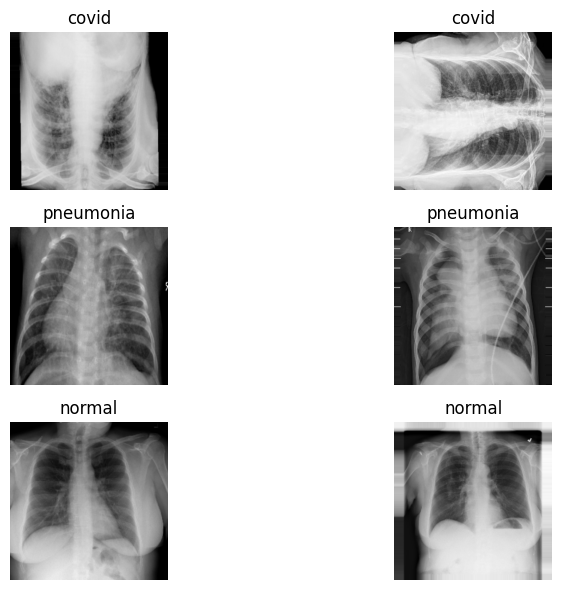

In [39]:
import numpy as np

def get_images_from_classes(generator, classes, images_per_class=2):
    class_indices = generator.class_indices  # e.g. {'covid': 0, 'normal': 1, 'pneumonia': 2}
    indices_to_collect = {class_indices[c]: [] for c in classes}
    images_collected = {c: [] for c in classes}

    # Iterate over generator batches until enough images are collected
    while any(len(images_collected[c]) < images_per_class for c in classes):
        batch_imgs, batch_labels = next(generator)
        batch_classes = np.argmax(batch_labels, axis=1)
        for i, class_id in enumerate(batch_classes):
            for c in classes:
                if class_id == class_indices[c] and len(images_collected[c]) < images_per_class:
                    images_collected[c].append(batch_imgs[i])

        # Break if generator is exhausted (optional, depends on your generator setup)
        # You may add a max iteration limit to avoid infinite loops

    return images_collected

# Usage Example:

classes = ['covid', 'pneumonia', 'normal']
images_per_class = 2
images_dict = get_images_from_classes(train_generator, classes, images_per_class)

# Now, images_dict['covid'], images_dict['pneumonia'], images_dict['normal'] each contain 2 images as numpy arrays

# Example to display the images:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(classes), images_per_class, figsize=(10, 6))
for row, c in enumerate(classes):
    for col in range(images_per_class):
        axes[row, col].imshow(images_dict[c][col])
        axes[row, col].set_title(c)
        axes[row, col].axis('off')
plt.tight_layout()
plt.show()


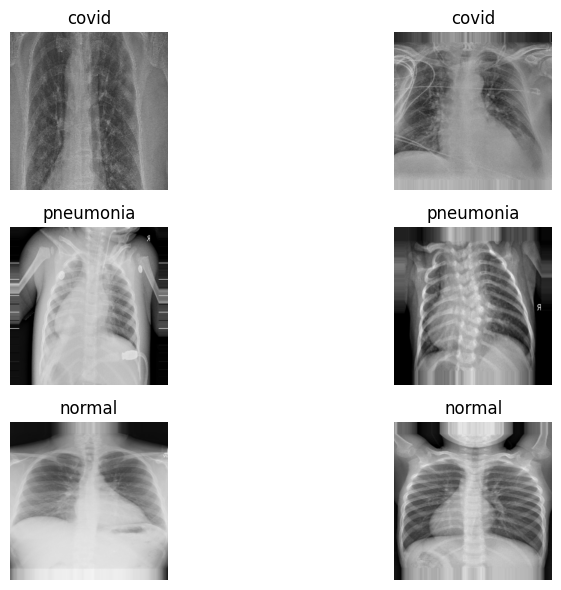

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ExifTags

def correct_image_rotation(img_array):
    # Convert numpy array to PIL Image
    img = Image.fromarray((img_array * 255).astype(np.uint8) if img_array.max() <= 1 else img_array.astype(np.uint8))
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation]=='Orientation':
                break
        exif=dict(img._getexif().items())
        if exif[orientation] == 3:
            img = img.rotate(180, expand=True)
        elif exif[orientation] == 6:
            img = img.rotate(270, expand=True)
        elif exif[orientation] == 8:
            img = img.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError, TypeError):
        # Cases: image has no EXIF data
        pass
    return np.array(img)

def get_images_from_classes(generator, classes, images_per_class=2):
    class_indices = generator.class_indices
    images_collected = {c: [] for c in classes}

    while any(len(images_collected[c]) < images_per_class for c in classes):
        batch_imgs, batch_labels = next(generator)
        batch_classes = np.argmax(batch_labels, axis=1)
        for i, class_id in enumerate(batch_classes):
            for c in classes:
                if class_id == class_indices[c] and len(images_collected[c]) < images_per_class:
                    # Correct rotation before saving
                    rotated_img = correct_image_rotation(batch_imgs[i])
                    images_collected[c].append(rotated_img)
        # Optional: break according to your needs to avoid infinite loop
    return images_collected

# Usage:
classes = ['covid', 'pneumonia', 'normal']
images_per_class = 2
images_dict = get_images_from_classes(train_generator, classes, images_per_class)

# Display images
fig, axes = plt.subplots(len(classes), images_per_class, figsize=(10, 6))
for row, c in enumerate(classes):
    for col in range(images_per_class):
        axes[row, col].imshow(images_dict[c][col])
        axes[row, col].set_title(c)
        axes[row, col].axis('off')
plt.tight_layout()
plt.show()
